- Compute returns from the real data.
- Pre-define the hit rate and calculate predictions, hits and confidence intervals.
- Show PnL and Sharpe Ratio for the corresponding parameters.
- Bootstrapping to compute pnl = f(hit_rate).

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

import core.config.config_ as cconconf
import core.finance as cofinanc
import core.finance.resampling as cfinresa
import core.finance.tradability as cfintrad
import core.plotting.misc_plotting as cplmiplo
import core.statistics.sharpe_ratio as cstshrat
import helpers.hdbg as hdbg
import helpers.hpandas as hpandas
import helpers.hprint as hprint

/app/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-70823e7c-7cd5-4245-abf1-9b8be2099188.json'


# Config

In [3]:
def get_synthetic_data_config() -> cconconf.Config:
    """
    Get config that specifies params for analysis.
    """
    config = cconconf.Config()
    # Data parameters.
    config.add_subconfig("data")
    # Reference price to calculate returns.
    config["data"]["reference_price"] = "close"
    # Returns mode: 'pct_change','log_rets' or 'diff'.
    config["data"]["rets_mode"] = "pct_change"
    # Check returns for an analysis: raw ('rets') or cleaned ('rets_cleaned').
    config["data"]["rets_col"] = "rets_cleaned"
    # Choose the timeframe for resampling.
    config["data"]["resampling_rule"] = "5T"
    # Number of periods for returns normalization.
    config["data"]["lookback_in_samples"] = 100
    return config

In [4]:
config = get_synthetic_data_config()
print(config)

data:
  reference_price: close
  rets_mode: pct_change
  rets_col: rets_cleaned
  resampling_rule: 5T
  lookback_in_samples: 100


# Functions

In [5]:
def compute_normalize_returns(
    df: pd.DataFrame,
    price_col: str,
    rets_mode: str,
    lookback: int,
    rets_col: str,
    plot_rets: bool,
) -> pd.DataFrame:
    """
    Calculate simple returns as well as normalized ones and plot the results.

    :param df: OHLCV data
    :param price_col: Price column that will be used to calculate returns
    :param rets_mode: "pct_change", "log_rets" or "diff"
    :param lookback: Number of periods for returns normalization
    :param rets_col: Column to plot ("rets" or "rets_cleaned")
    :param plot_rets: Whether or not plot returns
    :return: OHLCV data with returns and normalized returns
    """
    # Compute returns.
    df["rets"] = cofinanc.compute_ret_0(df[price_col], rets_mode)
    # Normalize returns.
    df["rets_cleaned"] = df["rets"]
    # Demean step.
    df["rets_cleaned"] -= df["rets_cleaned"].rolling(lookback).mean()
    # Risk adjustment.
    df["rets_cleaned"] /= df["rets_cleaned"].rolling(lookback).std()
    # Remove NaNs.
    df = hpandas.dropna(df, report_stats=True)
    if plot_rets:
        df[rets_col].plot()
    return df

# Extract returns from the real data

## Load BTC data from `crypto-chassis` (shared_data folder)

In [6]:
btc_df = pd.read_csv("/shared_data/BTC_one_year.csv", index_col="timestamp")
ohlcv_cols = [
    "open",
    "high",
    "low",
    "close",
    "volume",
]
btc_df.index = pd.to_datetime(btc_df.index)
btc_df = btc_df[ohlcv_cols]
btc_df.head(3)

,open,high,low,close,volume
timestamp,,,,,
2021-01-01 00:00:00+00:00,28923.63,28961.66,28913.12,28961.66,27.457032
2021-01-01 00:01:00+00:00,28961.67,29017.50,28961.01,29009.91,58.477501
2021-01-01 00:02:00+00:00,29009.54,29016.71,28973.58,28989.30,42.470329


## Process returns

INFO  removed rows with nans: 3403 / 105121 = 3.24%


,open,high,low,close,volume,rets,rets_cleaned
timestamp,,,,,,,
2021-01-01 16:35:00+00:00,29265.99,29312.20,29249.23,29282.12,90.798414,0.000551,0.257227
2021-01-01 16:40:00+00:00,29282.12,29303.92,29267.96,29273.82,109.552897,-0.000283,-0.238576
2021-01-01 16:45:00+00:00,29274.75,29334.67,29271.21,29331.98,107.881227,0.001987,1.089852
2021-01-01 16:50:00+00:00,29331.97,29346.31,29308.74,29314.26,99.703728,-0.000604,-0.409335
2021-01-01 16:55:00+00:00,29314.26,29360.00,29301.12,29302.33,126.183430,-0.000407,-0.284806


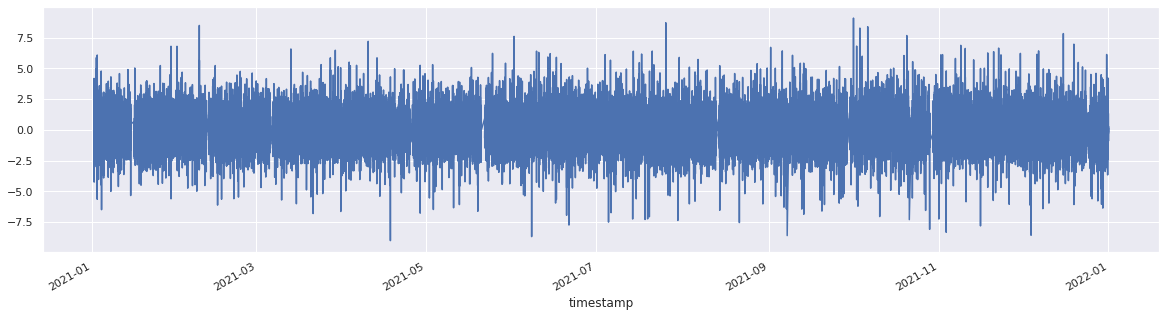

In [7]:
btc = btc_df.copy()
# Specify params.
price_col = config["data"]["reference_price"]
rets_mode = config["data"]["rets_mode"]
rets_col = config["data"]["rets_col"]
lookback_in_samples = config["data"]["lookback_in_samples"]
resampling_rule = config["data"]["resampling_rule"]
# Resample.
btc = cfinresa.resample_ohlcv_bars(btc, resampling_rule)
# Add returns.
btc = compute_normalize_returns(
    btc, price_col, rets_mode, lookback_in_samples, rets_col, plot_rets=True
)
# Show snippet.
display(btc.head())

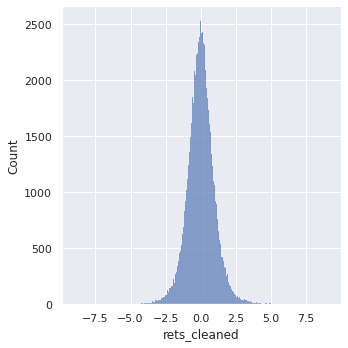

In [8]:
# Show the distribution of returns.
rets_col = config["data"]["rets_col"]
sns.displot(btc, x=rets_col)

# Pre-defined Predictions, Hit Rates and Confidence Interval

In [9]:
# Specify params.
sample = btc
ret_col = config["data"]["rets_col"]
hit_rate = 0.505
seed = 2
alpha = 0.05
method = "normal"
# Calculate and attach `predictions` and `hit` to the OHLCV data.
btc[["rets_cleaned", "predictions", "hit"]] = cfintrad.get_predictions_and_hits(
    sample, ret_col, hit_rate, seed
)
display(btc.tail(3))
# Shpw CI stats.
cfintrad.calculate_confidence_interval(btc["hit"], alpha, method)

,open,high,low,close,volume,rets,rets_cleaned,predictions,hit
timestamp,,,,,,,,,
2021-12-31 23:50:00+00:00,46433.80,46448.97,46347.80,46347.81,61.60456,-0.001852,-0.807040,1.0,False
2021-12-31 23:55:00+00:00,46347.81,46366.09,46250.55,46252.69,115.92977,-0.002052,-0.902346,1.0,False
2022-01-01 00:00:00+00:00,46252.68,46279.40,46132.04,46250.00,168.96267,-0.000058,0.160724,-1.0,False


hit_rate: 50.5004030751686
hit_rate_lower_CI_(97.5%): 50.19314915098209
hit_rate_upper_CI_(97.5%): 50.80765699935511


sharpe_ratio                   14.939628
sharpe_ratio_standard_error     1.196905
dtype: float64

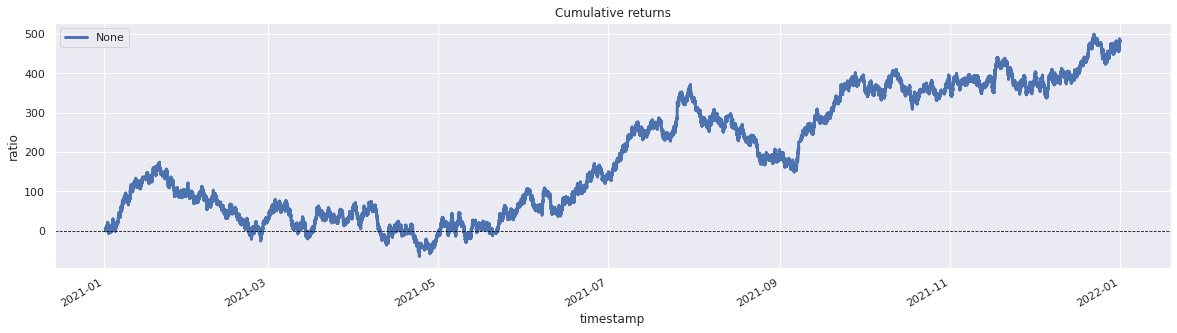

In [10]:
## Show PnL for the current `hit_rate`
pnl = (btc["predictions"] * btc[ret_col]).cumsum()
pnl = pnl[pnl.notna()]
cplmiplo.plot_cumulative_returns(pnl, mode="pct")
# Sharpe ratio.
cstshrat.summarize_sharpe_ratio(pnl)

# PnL as a function of `hit_rate`

In [11]:
# Specify params.
sample = btc
rets_col = config["data"]["rets_col"]
hit_rates = np.linspace(0.4, 0.6, num=10)
n_experiment = 10
# Perform the simulattion.
pnls = cfintrad.simulate_pnls_for_set_of_hit_rates(
    sample, rets_col, hit_rates, n_experiment
)

<AxesSubplot:xlabel='hit_rate', ylabel='PnL'>

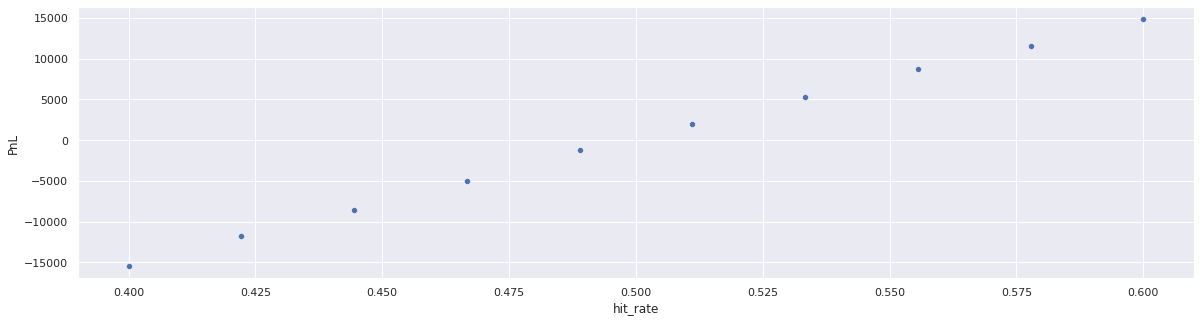

In [12]:
hit_pnl_df = pd.DataFrame(pnls.items(), columns=["hit_rate", "PnL"])
sns.scatterplot(data=hit_pnl_df, x="hit_rate", y="PnL")

R-squared = 0.9993


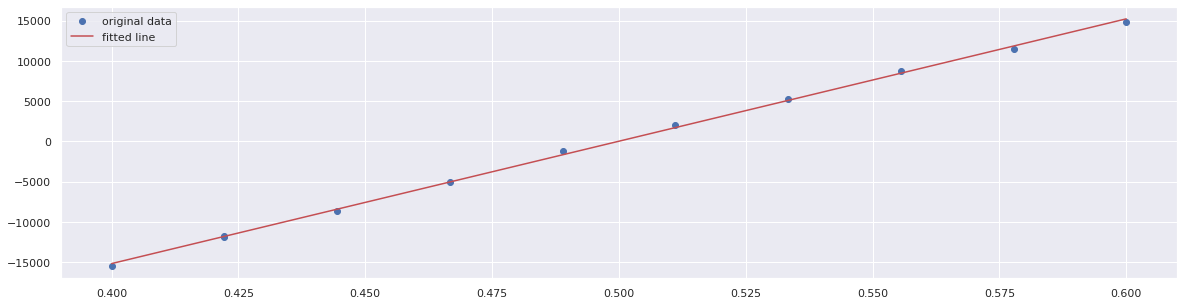

In [13]:
x = hit_pnl_df["hit_rate"]
y = hit_pnl_df["PnL"]

ols_results = stats.linregress(x, y)
print(f"R-squared = {ols_results.rvalue**2:.4f}")
plt.plot(x, y, "o", label="original data")
plt.plot(
    x, ols_results.intercept + ols_results.slope * x, "r", label="fitted line"
)
plt.legend()
plt.show()